# Used Car Price Prediction

This notebook presents a predictive modeling project focused on predicting the selling prices of second-hand cars in Myanmar. The model development initiative was carried out as part of a freelance project undertaken for a reputable auction car platform in Myanmar. The dataset used in this project has undergone some modifications to safeguard data confidentiality of the original dataset.

Within this notebook, we will delve into the comprehensive process of exploring a multi-linear regression model and random forest model for the purpose of predicting used car prices. Our analysis will encompass 

1. Exploratory Data Analysis (EDA)
2. Feature Engineering
3. Model Evaluation
4. Final Model Fit

The ultimate objective is to deliver precise and reliable pricing forecasts that can be valuable in the context of the used car market.


## 1. EDA

In [1]:
#Loading necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


#To surpress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
used_cars = pd.read_csv("C:\\Yadanar\\Learning Resources\\Datasets\\used_cars_data.csv")

used_cars.head()

,car_id,year,car_brand,car_name,engine_power,mileage_thousand_km,colour,steering_position,transmission,fuel_type,body_type,price_mmk,price_usd
0,1,2007,toyota,belta,1.3,170,others,rhd,auto,petrol,Sedan,"15,500,000","11,071"
1,2,2009,toyota,belta,1.3,90,others,rhd,auto,petrol,Sedan,"18,500,000","13,214"
2,3,2007,toyota,belta,1.3,130,others,rhd,auto,petrol,Sedan,"16,500,000","11,786"
3,4,2007,toyota,belta,1.3,100,others,rhd,auto,petrol,Sedan,"16,000,000","11,429"
4,5,2012,toyota,belta,1.0,100,others,rhd,auto,petrol,Sedan,"14,300,000","10,214"


In [3]:
#checking data types

used_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_id               500 non-null    int64  
 1   year                 500 non-null    int64  
 2   car_brand            500 non-null    object 
 3   car_name             500 non-null    object 
 4   engine_power         500 non-null    float64
 5   mileage_thousand_km  500 non-null    int64  
 6   colour               500 non-null    object 
 7   steering_position    500 non-null    object 
 8   transmission         500 non-null    object 
 9   fuel_type            500 non-null    object 
 10  body_type            500 non-null    object 
 11  price_mmk            500 non-null    object 
 12  price_usd            500 non-null    object 
dtypes: float64(1), int64(3), object(9)
memory usage: 50.9+ KB


Observations:

1. It is more effective to transform the "year" (the year the car was manufactured) to "age" as the "year" alone does not provide any insights.
2. We can also drop one of the price features as it is redundant. Since "USD" is a global currency, we will keep the price_usd feature.


In [4]:
#drop car_id, year and price_mmk columns

used_cars = (used_cars
    .assign(age = 2024 - used_cars["year"])
    .drop(["car_id", "year","price_mmk"], axis = 1)
)

used_cars.head()

,car_brand,car_name,engine_power,mileage_thousand_km,colour,steering_position,transmission,fuel_type,body_type,price_usd,age
0,toyota,belta,1.3,170,others,rhd,auto,petrol,Sedan,"11,071",17
1,toyota,belta,1.3,90,others,rhd,auto,petrol,Sedan,"13,214",15
2,toyota,belta,1.3,130,others,rhd,auto,petrol,Sedan,"11,786",17
3,toyota,belta,1.3,100,others,rhd,auto,petrol,Sedan,"11,429",17
4,toyota,belta,1.0,100,others,rhd,auto,petrol,Sedan,"10,214",12


In [5]:
# change the price_usd into integer datatype

used_cars["price_usd"] = (used_cars["price_usd"]
    .str.replace(',','')
    .str.strip()
    .astype("int")
)

In [6]:
used_cars.describe()

,engine_power,mileage_thousand_km,price_usd,age
count,500.000000,500.000000,500.000000,500.000000
mean,1.911440,110.908000,17749.788000,17.582000
std,0.814889,46.732595,7537.223367,4.957866
min,0.660000,5.000000,4857.000000,5.000000
25%,1.300000,90.000000,12357.000000,14.000000
50%,1.800000,100.000000,16071.000000,18.000000
75%,2.400000,140.000000,22553.500000,21.000000
max,4.900000,300.000000,53214.000000,29.000000


<Axes: xlabel='price_usd', ylabel='Count'>

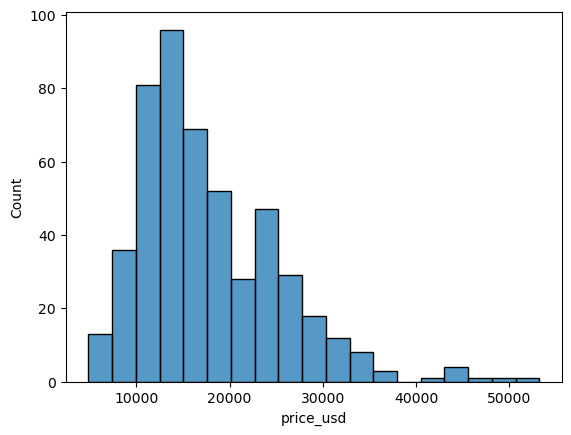

In [7]:
# Checking data distribution of price 

sns.histplot(used_cars["price_usd"])

<Axes: xlabel='engine_power', ylabel='Count'>

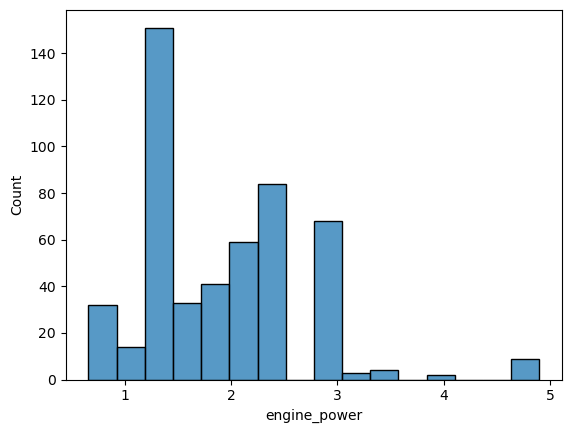

In [8]:
sns.histplot(used_cars["engine_power"])

<Axes: xlabel='mileage_thousand_km', ylabel='Count'>

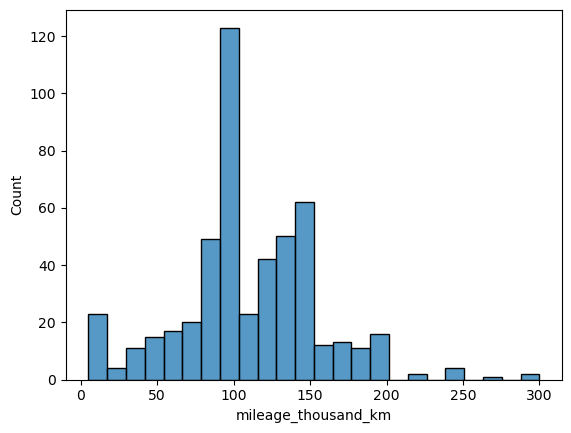

In [9]:
sns.histplot(used_cars["mileage_thousand_km"])

The data is right skewed. We might need to conduct data transformation.

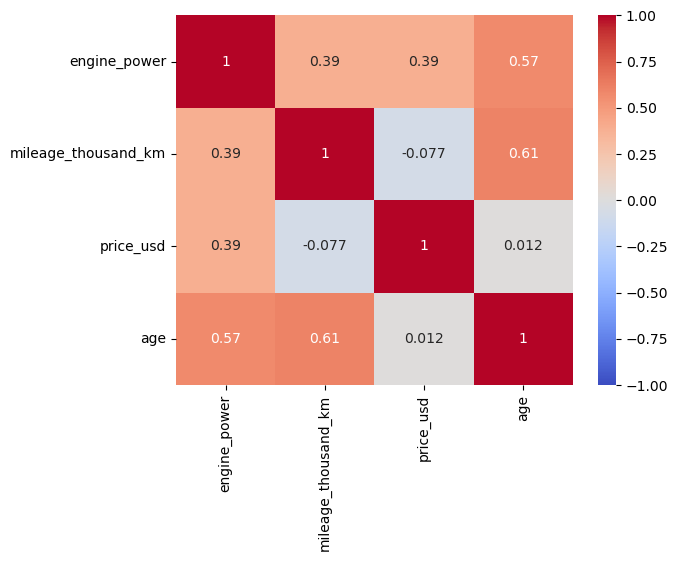

In [10]:
#Checking target-feature relationship and feature-feature relationships

sns.heatmap(
    used_cars.corr(numeric_only = True),
    vmin = -1,
    vmax = 1,
    cmap ="coolwarm",
    annot = True
);

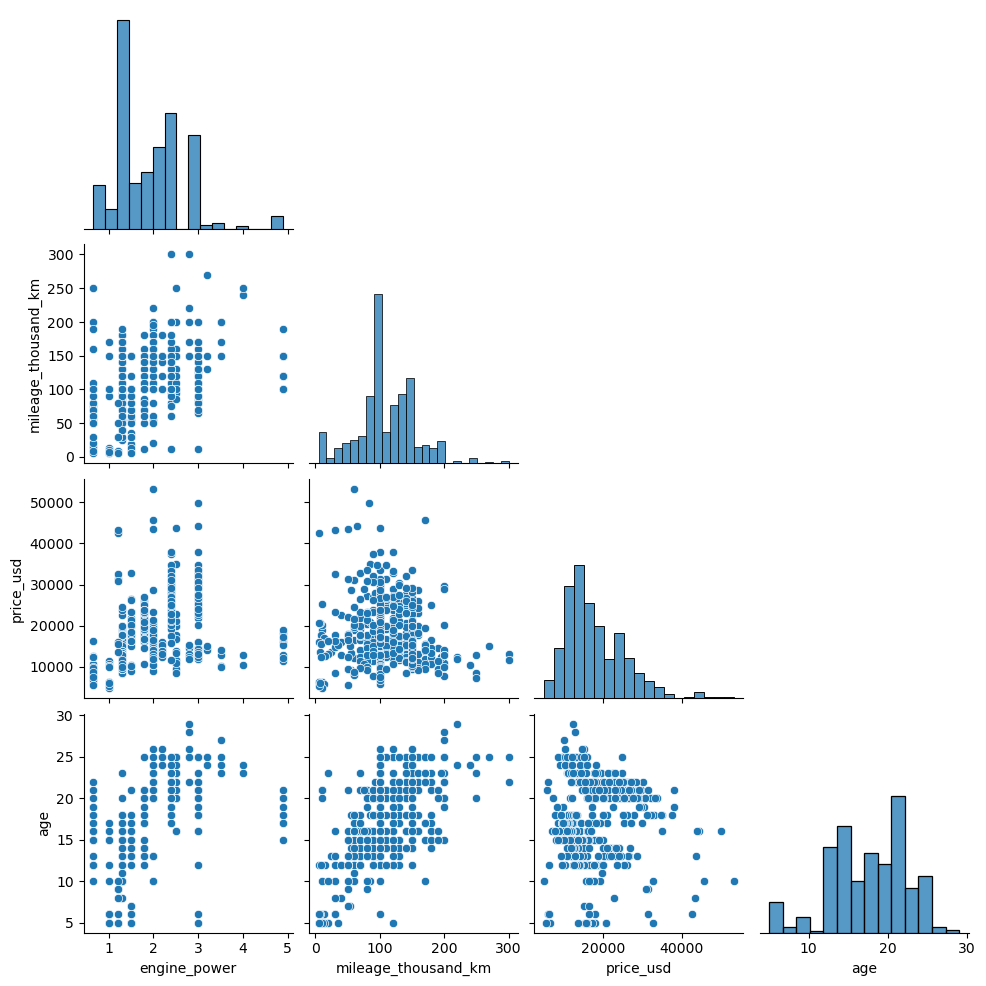

In [11]:
sns.pairplot(used_cars, corner = True)

It seems that the target variable "price_usd" does not have correlation with numeric features.

A few of the numeric features are also correlated to each other

We should explore the relationships between target and categorical features

In [12]:
#Checking the frequency of categorical values


def value_count(dataframe):
    value_series = pd.DataFrame()
    for col in dataframe.select_dtypes(["object"]).columns:
        print(dataframe[col].value_counts())
        
value_count(used_cars)


car_brand
toyota        280
honda          80
nissan         40
mitsubishi     40
suzuki         30
daihatsu       30
Name: count, dtype: int64
car_name
belta          35
alphard        35
mark 2         35
corolla        35
crown          35
kluger         35
harrier        35
wish           35
insight        30
fit            30
hijet          30
ad_van         22
cr-v           20
pajero         17
juke           13
rvr            13
carry          10
swift          10
ertiga         10
fuso canter    10
qashqai         5
Name: count, dtype: int64
colour
white     209
others    173
black      88
silver     30
Name: count, dtype: int64
steering_position
rhd    472
lhd     28
Name: count, dtype: int64
transmission
auto         374
semi auto     89
manual        37
Name: count, dtype: int64
fuel_type
petrol    478
diesel     22
Name: count, dtype: int64
body_type
Sedan       140
SUV         138
Van         132
Truck        50
Mini-Van     40
Name: count, dtype: int64


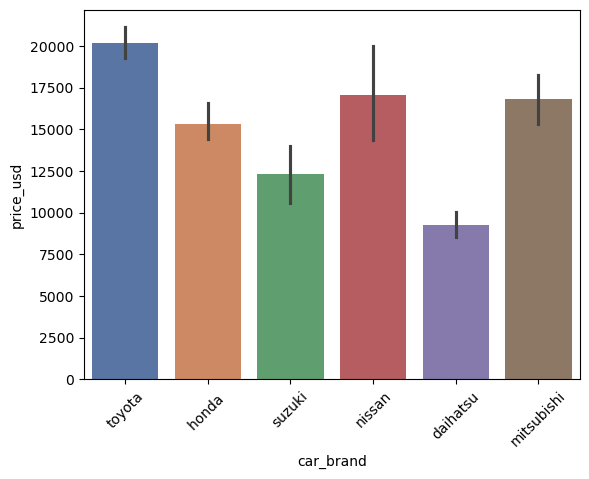

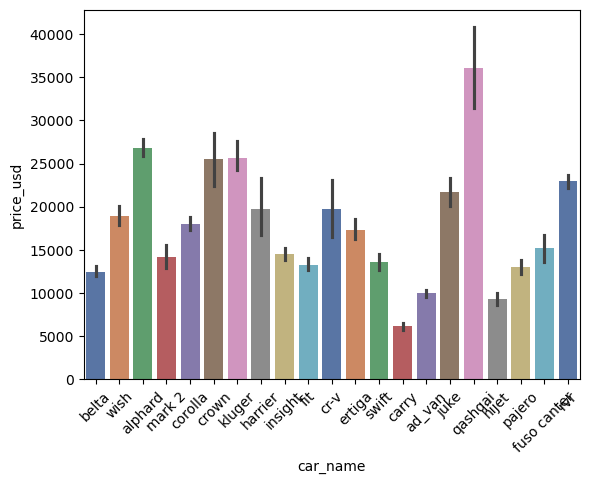

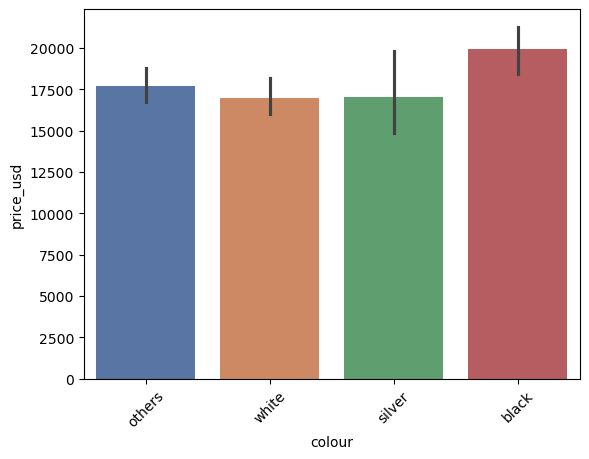

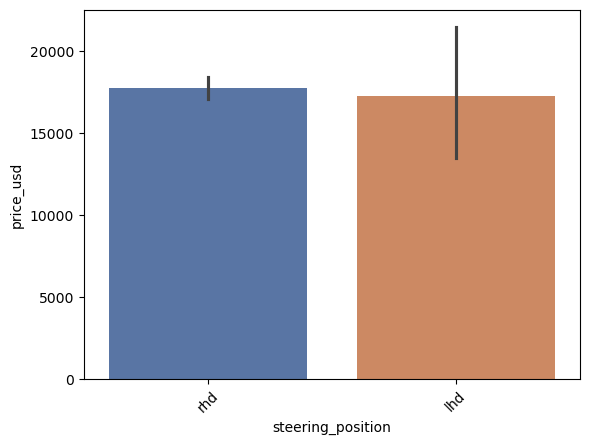

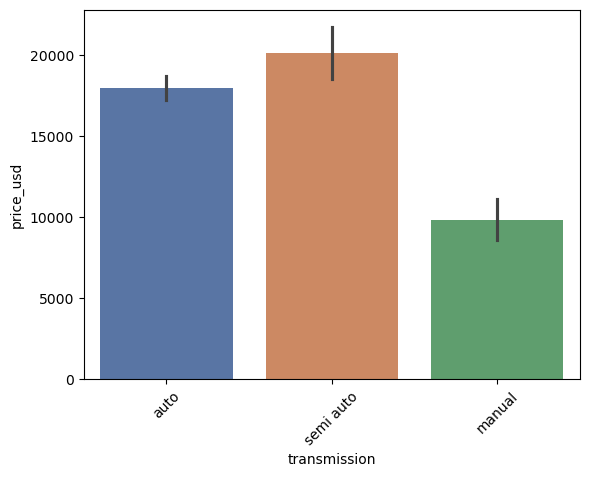

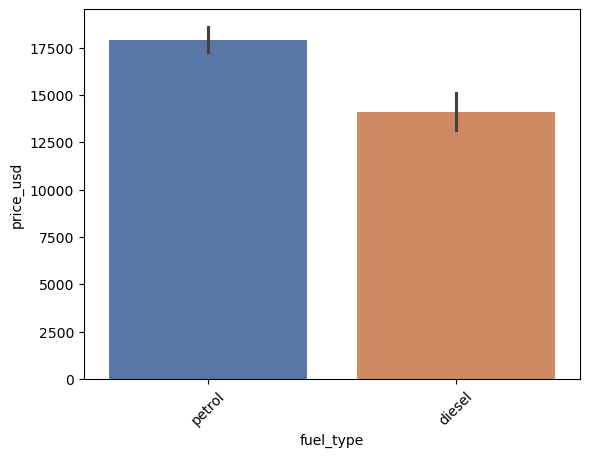

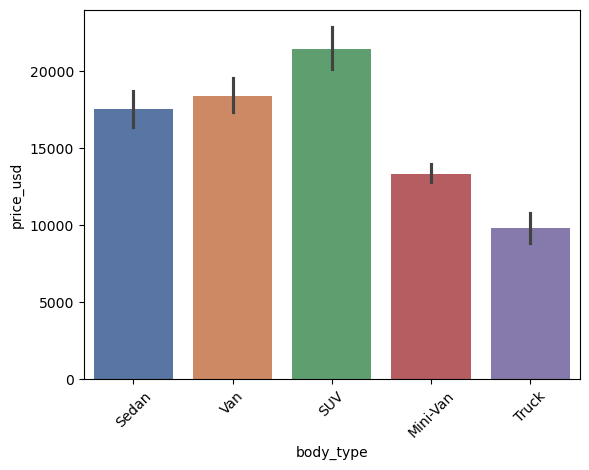

In [13]:
#Checking the price breakdown by the categorical features

def category_plot(dataframe, target):
    for col in dataframe.select_dtypes(["object"]).columns:
        sns.barplot(data = dataframe, x=col, y=target, palette = "deep")
        plt.xticks(rotation = 45)
        plt.show()

category_plot(used_cars, "price_usd")


The samples of the categories are quite imbalanced. 

We should consider combining some features and drop some features.

1. Car brand - Based on price breakdowns, we can recategorise this variable: high-end brands (Toyota), mid-range brands (Honda,Nissan,Mitsubishi), low-end brands (Suzuki, Daihatsu)
   In Myanmar, Toyota has traditionally been a dominant player in the automotive market so Toyota being the majority of samples    makes sense
2. Car name - The price gaps appear to be significant between different car makes. As it has several categories, we can consider regrouping to narrow down the categories or we can try regularisation.
3. Colour - Black cars seem to be more expensive. So, we can recategorise: "black" and "non-black"
4. Steering Position - Right hand drive makes up the vast majority of the samples. (This also aligns with the Myanmar market given the left hand drive cars were introduced to the market only recently). There is no price difference between the two as well. So, we can drop this feature as it does not add any additional insight
5. Transmission - We can combine "semi-auto" and manual into "non-auto"
6. Fuel Type - although "diesel" types have few samples, there seems to be a significant price difference.
6. Body type - We can combine "Van" and "Mini-van" into one category.


## 2. Feature Engineering

In [14]:
car_brand_map = {
    "toyota" : "high_end_brands",
    "honda" : "mid_range_brands",
    "nissan" : "mid_range_brands",
    "mitsubishi" : "mid_range_brands",
    "suzuki" : "low_end_brands",
    "daihatsu" : "low_end_brands"
}

colour_map = {
    "black" : "black",
    "others" : "non_black",
    "white" :"non_black",
    "silver" : "non_black"
}

transmission_map = {
    "auto" : "auto",
    "semi auto" : "non_auto",
    "manual" : "non_auto"
}

In [15]:
#Creating a new dataframe for feature engineering

used_cars_eng = (used_cars.assign(
        car_brand = used_cars["car_brand"].map(car_brand_map),
        colour = used_cars["colour"].map(colour_map),
        transmission = used_cars["transmission"].map(transmission_map),
        engine_power2 = used_cars["engine_power"] ** 2,
        engine_power3 = used_cars["engine_power"] ** 3,
        mileage2 = used_cars["mileage_thousand_km"] ** 2,
        mileage3 = used_cars["mileage_thousand_km"] ** 3)
        .drop(["steering_position"],axis =1)
)


#Transforming the categorical variables into binary values
used_cars_eng = pd.get_dummies(used_cars_eng, drop_first = True, dtype = int)

used_cars_eng.head()
                

,engine_power,mileage_thousand_km,price_usd,age,engine_power2,engine_power3,mileage2,mileage3,car_brand_low_end_brands,car_brand_mid_range_brands,...,car_name_rvr,car_name_swift,car_name_wish,colour_non_black,transmission_non_auto,fuel_type_petrol,body_type_SUV,body_type_Sedan,body_type_Truck,body_type_Van
0,1.3,170,11071,17,1.69,2.197,28900,4913000,0,0,...,0,0,0,1,0,1,0,1,0,0
1,1.3,90,13214,15,1.69,2.197,8100,729000,0,0,...,0,0,0,1,0,1,0,1,0,0
2,1.3,130,11786,17,1.69,2.197,16900,2197000,0,0,...,0,0,0,1,0,1,0,1,0,0
3,1.3,100,11429,17,1.69,2.197,10000,1000000,0,0,...,0,0,0,1,0,1,0,1,0,0
4,1.0,100,10214,12,1.00,1.000,10000,1000000,0,0,...,0,0,0,1,0,1,0,1,0,0


## 3. Model Evaluation

### Multi-Linear Regression

In [16]:
from sklearn.model_selection import train_test_split

target = "price_usd"

# To drop features based on model coefficients
drop_cols = [
    "colour_non_black",
    "fuel_type_petrol"
]


X = sm.add_constant(used_cars_eng.drop(["price_usd"] + drop_cols,axis=1))
y = np.log(used_cars_eng["price_usd"])

# Spliting training and test sets

X,X_test,y,y_test = train_test_split(X,y, test_size = .2, random_state = 2024)

In [17]:
# Cross-validation

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae


def cross_validation(X,y,n_splits):
    kf = KFold (n_splits = n_splits, shuffle = True, random_state = 2024)
    
    #Storing validation scores 
    cv_train_r2s = []
    cv_train_mae = []
    cv_val_r2s = []
    cv_val_mae =[]
    
    #Loop through cv folds
    for train_ind, val_ind in kf.split(X,y):
        #Subset data based on folds
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        #Fitting the model on each train
        model = sm.OLS(y_train, X_train).fit()
        #Append training and validation scores to the list
        cv_train_r2s.append(r2(y_train,model.predict(X_train)))
        cv_train_mae.append(mae(np.exp(y_train), np.exp(model.predict(X_train))))
        cv_val_r2s.append(r2(y_val, model.predict(X_val),))
        cv_val_mae.append(mae(np.exp(y_val), np.exp(model.predict(X_val),)))
        

        print(f"All training R2s : {[round(x,3) for x in cv_train_r2s]}")
        print(f"Training R2s : {round(np.mean(cv_train_r2s), 3)} +- {round(np.std(cv_train_r2s),3)}")
        
        print(f"All training MAE : {[round(x,3) for x in cv_train_mae]}")
        print(f"Training MAE : {round(np.mean(cv_train_mae), 3)} +- {round(np.std(cv_train_mae),3)}")
        
        print(f"All validation R2s : {[round(x,3) for x in cv_val_r2s]}")
        print(f"Validation R2s : {round(np.mean(cv_val_r2s), 3)} +- {round(np.std(cv_val_r2s),3)}")
        
        print(f"All validation R2s : {[round(x,3) for x in cv_val_r2s]}")
        print(f"Validation MAE : {round(np.mean(cv_val_mae), 3)} +- {round(np.std(cv_val_mae),3)}")
        
        return model
        
model = cross_validation(X,y,5)

All training R2s : [0.856]
Training R2s : 0.856 +- 0.0
All training MAE : [2192.569]
Training MAE : 2192.569 +- 0.0
All validation R2s : [0.823]
Validation R2s : 0.823 +- 0.0
All validation R2s : [0.823]
Validation MAE : 2583.083 +- 0.0


In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_usd   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     61.65
Date:                Tue, 06 Feb 2024   Prob (F-statistic):          2.33e-105
Time:                        13:59:08   Log-Likelihood:                 149.38
No. Observations:                 320   AIC:                            -240.8
Df Residuals:                     291   BIC:                            -131.5
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          8.4059      0.321     26.193      0.000       7.774       9.038
engine_power                   0.3124      0.447      0.699      0.485      -0.567       1.192
mileage_thousand_km            0.0034      0.002      2.144      0.033       0.000       0.006
age                           -0.0550      0.004    -14.050      0.000      -0.063      -0.047
engine_power2                 -0.1563      0.156     -0.999      0.318      -0.464       0.151
engine_power3                  0.0204      0.018      1.158      0.248      -0.014       0.055
mileage2                   -3.142e-05   1.24e-05     -2.529      0.012   -5.59e-05   -6.97e-06
mileage3                    6.549e-08      3e-08      2.185      0.030     6.5e-09    1.24e-07
car_brand_low_end_brands       0.3985      0.044      9.064      0.000       0.312       0.485
car_brand_mid_range_brands     0.1354      0.034      4.033      0.000       0.069       0.202
car_name_alphard               1.5355      0.082     18.622      0.000       1.373       1.698
car_name_belta                -0.0244      0.044     -0.552      0.582      -0.112       0.063
car_name_carry                -0.4903      0.069     -7.127      0.000      -0.626      -0.355
car_name_corolla               0.2247      0.039      5.833      0.000       0.149       0.301
car_name_cr-v                  0.3521      0.058      6.064      0.000       0.238       0.466
car_name_crown                 0.9276      0.065     14.234      0.000       0.799       1.056
car_name_ertiga               -0.2449      0.069     -3.548      0.000      -0.381      -0.109
car_name_fit                   1.6319      0.065     25.168      0.000       1.504       1.759
car_name_fuso canter           1.1575      0.153      7.577      0.000       0.857       1.458
car_name_harrier               0.5870      0.058     10.109      0.000       0.473       0.701
car_name_hijet                 0.1959      0.090      2.187      0.030       0.020       0.372
car_name_insight               0.3989      0.046      8.723      0.000       0.309       0.489
car_name_juke                 -0.1869      0.062     -3.025      0.003      -0.308      -0.065
car_name_kluger                0.7311      0.054     13.558      0.000       0.625       0.837
car_name_mark 2                0.5241      0.063      8.262      0.000       0.399       0.649
car_name_pajero                0.3565      0.079      4.497      0.000       0.200       0.512
car_name_qashqai               0.1101      0.106      1.040      0.299      -0.098       0.319
car_name_rvr                   0.0982      0.055      1.779      0.076      -0.010       0.207
car_name_swift                 0.9379      0.076     12.331      0.000       0.788       1.088
car_name_wish                  0.9835      

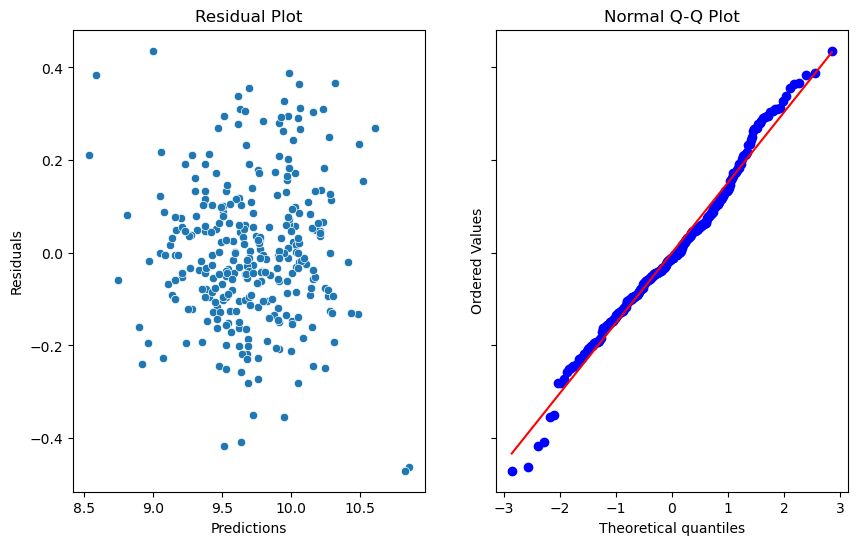

In [19]:
# Checking regression assumptions

def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    resids = model.resid
    
    fig, ax=plt.subplots(1,2, sharey="all", figsize = (10,6))
    
    sns.scatterplot(x=predictions, y=resids, ax=ax[0])
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Predictions")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(resids,dist = "norm", plot = ax[1])
    ax[1].set_title("Normal Q-Q Plot")
    
residual_analysis_plots(model)

In [20]:
#Checking outliers

influence = model.get_influence()
influence_df = influence.summary_frame()
influence_df["cooks_d"].sort_values(ascending= False).head()

479    0.437707
385    0.170894
179    0.059861
183    0.052066
380    0.032818
Name: cooks_d, dtype: float64

Cooks distance scores look okay. However, it is better to investigate these observations to determine whether to remove them or not.

In [21]:
#Creating a dataframe for most influential data points

outliers_df = used_cars.loc[[479,385,179,183,380]]

outliers_df.head()

,car_brand,car_name,engine_power,mileage_thousand_km,colour,steering_position,transmission,fuel_type,body_type,price_usd,age
479,mitsubishi,fuso canter,3.00,150,white,rhd,manual,diesel,Truck,13071,18
385,suzuki,carry,0.66,100,others,rhd,auto,petrol,Truck,7857,15
179,toyota,crown,3.00,120,white,rhd,auto,petrol,Sedan,32714,5
183,toyota,crown,3.00,100,black,rhd,auto,petrol,Sedan,31429,6
380,suzuki,carry,0.66,6,white,rhd,manual,petrol,Truck,6286,12


In [22]:
#Since Fuso Canter has the highest cooks distance, we want to look into this model specifically.

fuso_df = used_cars[used_cars["car_name"] == "fuso canter"]

fuso_df.head(10)

,car_brand,car_name,engine_power,mileage_thousand_km,colour,steering_position,transmission,fuel_type,body_type,price_usd,age
477,mitsubishi,fuso canter,4.9,190,white,rhd,manual,diesel,Truck,11429,20
478,mitsubishi,fuso canter,4.9,150,white,rhd,manual,diesel,Truck,12857,18
479,mitsubishi,fuso canter,3.0,150,white,rhd,manual,diesel,Truck,13071,18
480,mitsubishi,fuso canter,4.9,120,white,rhd,manual,diesel,Truck,18214,17
481,mitsubishi,fuso canter,4.9,120,white,rhd,manual,diesel,Truck,18929,15
482,mitsubishi,fuso canter,4.9,120,white,rhd,manual,diesel,Truck,16000,17
483,mitsubishi,fuso canter,4.9,150,others,rhd,manual,diesel,Truck,15214,21
484,mitsubishi,fuso canter,4.9,100,white,rhd,manual,diesel,Truck,17000,19
485,mitsubishi,fuso canter,4.9,150,white,rhd,manual,diesel,Truck,12143,20
486,mitsubishi,fuso canter,4.9,100,white,rhd,manual,diesel,Truck,17143,18


It seems that the unique engine power of index 479 possibly makes this data point influential on the model. However, as the cooks distance score is less than 1, we will keep it. 

In [23]:
#Checking VIF scores for multi-collinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)

const                         0.000000e+00
engine_power                  1.583965e+03
mileage_thousand_km           6.750124e+01
age                           4.778529e+00
engine_power2                 4.786025e+03
engine_power3                 1.286890e+03
mileage2                      2.498864e+02
mileage3                      8.472621e+01
car_brand_low_end_brands               inf
car_brand_mid_range_brands             inf
car_name_alphard                       inf
car_name_belta                         inf
car_name_carry                         inf
car_name_corolla                       inf
car_name_cr-v                          inf
car_name_crown                         inf
car_name_ertiga                        inf
car_name_fit                           inf
car_name_fuso canter                   inf
car_name_harrier                       inf
car_name_hijet                         inf
car_name_insight                       inf
car_name_juke                          inf
car_name_kl

Assumptions Evaluation

1. Linearity  - No obvious pattern that violates linearity
2. Independence - Durbin Watson test score between 1.5 and 2.5 is acceptable
3. Normality - Normal Q-Q plot is better after log transformation
4. Multi-collinearity - Numerical variables have vif values less than 10 so it's fine to proceed.
5. Homoscedasticity - Residuals seem to be scattered randomly with no clear patterns. There is a slight indication that the variance of residuals increase as the predictions increase but it is not very pronounced.

### Regularisation

In [24]:
# Regularisation

from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_train_ridge = std.fit_transform(X.values)
X_test_ridge = std.transform(X_test.values)

In [25]:
# Ridge Model

from sklearn.linear_model import RidgeCV

n_alphas = 100
alphas = 10 ** np.linspace(-3,3,n_alphas)

ridge_model = RidgeCV(alphas = alphas, cv = 5)

ridge_model.fit(X_train_ridge,y)

print(f"Cross Validation R2: {ridge_model.score(X_train_ridge,y)}")
print(f"Cross Validation MAE: {mae(np.exp(y), np.exp(ridge_model.predict(X_train_ridge)))}")
print(f"Alpha value: {ridge_model.alpha_}")

Cross Validation R2: 0.850592989402208
Cross Validation MAE: 2225.372373053985
Alpha value: 3.7649358067924674


In [26]:
# Lasso Model

from sklearn.linear_model import LassoCV

n_alphas = 200
alphas = 10 ** np.linspace(-2,3,n_alphas)

lasso_model = LassoCV(alphas = alphas, cv = 5)

lasso_model.fit(X_train_ridge,y)

print(f"Cross Validation R2: {lasso_model.score(X_train_ridge,y)}")
print(f"Cross Validation MAE: {mae(np.exp(y), np.exp(lasso_model.predict(X_train_ridge)))}")
print(f"Alpha value: {lasso_model.alpha_}")

Cross Validation R2: 0.8153299746485988
Cross Validation MAE: 2401.5064722313714
Alpha value: 0.01


In [27]:
#Checking coefficient estimates of features

list(zip(X.columns, lasso_model.coef_))

[('const', 0.0),
 ('engine_power', 0.07285117360458615),
 ('mileage_thousand_km', -0.0),
 ('age', -0.18971596902442386),
 ('engine_power2', 0.0),
 ('engine_power3', 0.0),
 ('mileage2', -0.04563517364672404),
 ('mileage3', -0.0),
 ('car_brand_low_end_brands', -0.09472164751770497),
 ('car_brand_mid_range_brands', -0.0724658468550845),
 ('car_name_alphard', 0.1656525548916421),
 ('car_name_belta', -0.05610499196656301),
 ('car_name_carry', -0.11018165695472706),
 ('car_name_corolla', 0.0),
 ('car_name_cr-v', 0.0),
 ('car_name_crown', 0.09323277020983681),
 ('car_name_ertiga', 0.0),
 ('car_name_fit', -0.018995119849128342),
 ('car_name_fuso canter', 0.0),
 ('car_name_harrier', -0.0),
 ('car_name_hijet', -0.01255956743519902),
 ('car_name_insight', -0.0012470726243925163),
 ('car_name_juke', 0.0),
 ('car_name_kluger', 0.04327926688834045),
 ('car_name_mark 2', 0.0054198463829432724),
 ('car_name_pajero', -0.0),
 ('car_name_qashqai', 0.02879653737412808),
 ('car_name_rvr', 0.009203316050785

### Random Forest

In [28]:
X = sm.add_constant(used_cars_eng.drop(["price_usd"] + drop_cols,axis=1))
y = np.log(used_cars_eng["price_usd"])

# Spliting training and test sets

X,X_test,y,y_test = train_test_split(X,y, test_size = .2, random_state = 2024)
X_train,X_val,y_train,y_val = train_test_split(X,y, test_size = .5, random_state = 2024)

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [30]:
y_val_pred =rf_model.predict(X_val)

print(f"Validation R2: {r2(y_val,y_val_pred)}")
print(f"Validation MAE: {mae(np.exp(y_val),np.exp(y_val_pred))}")

Validation R2: 0.8380111941573014
Validation MAE: 2172.856091675998


Random Forest has the lowest error values. The R2 is slighlty lower than the Ridge model. As we want to have higher precision, we choose Random Forest Model.

## Final Model Selection

In [31]:
final_model= rf_model.fit(X,y)

print(f"R2: {r2(y_test,final_model.predict(X_test))}")
print(f"MAE: {mae(np.exp(y_test),np.exp(final_model.predict(X_test)))}")


R2: 0.8582269296265215
MAE: 2222.2152254682314


Upon evaluating the model's performance, it was evident that the inclusion of the 'car_name' variable significantly enhances the R² value, indicating a substantial contribution to the predictive accuracy. The variable's high cardinality was a concern; however, rigorous cross-validation and testing confirmed that the model with 'car_name' generalizes effectively to unseen data. Therefore, we retained this variable to leverage its predictive benefits while ensuring robust performance across various datasets